<a href="https://colab.research.google.com/github/kisung2577/CMPE-258/blob/main/3h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import jax
from jax import numpy as jnp
from jax import grad, value_and_grad
from jax.example_libraries import stax, optimizers
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Generate non-linear data
n = 600
dim = 3
x = np.random.uniform(-1, 1, (n, dim))
print('Input shape =', x.shape)

Input shape = (600, 3)


In [3]:
# Initialize weights and bias
weights = np.array([[2, -3, 1]]).T
bias = np.array([8])
print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)

# non-linear 3 variable function we want to learn
y_true = np.einsum('ij, jk -> ik', (x**3),  weights) + np.einsum('ij, jk -> ik', (x**2),  weights) + np.einsum('ij, jk -> ik', x, weights) + bias
print('Function output shape =', y_true.shape)

Weights shape = (3, 1)
Bias shape = (1,)
Function output shape = (600, 1)


In [4]:
# Hyperparamter initializations

input_dim = dim
output_dim = 1
hidden_dim = 16

learning_rate = 0.01
num_epochs = 50

seed = jax.random.PRNGKey(101)

#Using low-level API

In [5]:
def initialize_weights(input_dim, output_dim, hidden_dim, seed):
  weights = []

  # Weights for 1st hidden layer
  w = jax.random.uniform(key=seed, shape=(input_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])

  # Weights for 2nd hidden layer
  w = jax.random.uniform(key=seed, shape=(hidden_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])

  # Weights for output layer
  w = jax.random.uniform(key=seed, shape=(hidden_dim, output_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(output_dim,), dtype=jnp.float32)
  weights.append([w,b])

  return weights

In [6]:
# Non-linear activation function

def relu(x):
  return jnp.maximum(x, jnp.zeros_like(x))

In [7]:
# Linear layer

def linear(weights, input, activation=lambda x: x):
  weights, bias = weights
  out = jnp.dot(input, weights) + bias
  return activation(out)

In [8]:
# Forward pass

def forward(weights, input):
  layer_out = input

  for i in range(len(weights[:-1])):
    layer_out = linear(weights[i], layer_out, relu)

  preds = linear(weights[-1], layer_out)

  return preds.squeeze()

In [9]:
# Error function - Mean Square Error

def mean_squared_error(weights, input, actual):
    preds = forward(weights, input)
    return jnp.power(actual - preds, 2).mean()

In [10]:
# Computing gradients using JAX grad

def backward(weights, input, actual):
    loss = grad(mean_squared_error)
    gradients = loss(weights, input, actual)
    return gradients

In [11]:
# Train network

def train(weights, x, y_true, learning_rate, num_epochs):
  loss_ =  []

  for epoch in range(num_epochs):
    loss_value = mean_squared_error(weights, x, y_true)
    gradients = backward(weights, x, y_true)

    # Update Weights
    for j in range(len(weights)):
      weights[j][0] -= learning_rate * gradients[j][0] 
      weights[j][1] -= learning_rate * gradients[j][1]

    print(f'Epoch {epoch}, loss {loss_value}')
    loss_.append(loss_value)

  return loss_

In [12]:
# Initialize weights
weights = initialize_weights(input_dim, output_dim, hidden_dim, seed)

# Train model
loss_ = train(weights, x, y_true, learning_rate, num_epochs)

Epoch 0, loss 16.50585174560547
Epoch 1, loss 15.976628303527832
Epoch 2, loss 15.695318222045898
Epoch 3, loss 15.467085838317871
Epoch 4, loss 15.275958061218262
Epoch 5, loss 15.114917755126953
Epoch 6, loss 14.97708797454834
Epoch 7, loss 14.857584953308105
Epoch 8, loss 14.75370979309082
Epoch 9, loss 14.663254737854004
Epoch 10, loss 14.584296226501465
Epoch 11, loss 14.515229225158691
Epoch 12, loss 14.45443344116211
Epoch 13, loss 14.400781631469727
Epoch 14, loss 14.353110313415527
Epoch 15, loss 14.310754776000977
Epoch 16, loss 14.273127555847168
Epoch 17, loss 14.2395658493042
Epoch 18, loss 14.209342002868652
Epoch 19, loss 14.181991577148438
Epoch 20, loss 14.157437324523926
Epoch 21, loss 14.135189056396484
Epoch 22, loss 14.114897727966309
Epoch 23, loss 14.096355438232422
Epoch 24, loss 14.079562187194824
Epoch 25, loss 14.064197540283203
Epoch 26, loss 14.05008316040039
Epoch 27, loss 14.037059783935547
Epoch 28, loss 14.025110244750977
Epoch 29, loss 14.0140056610107

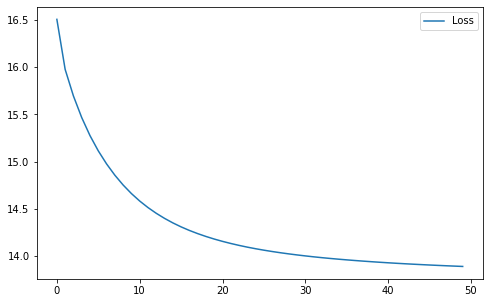

In [13]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()

#Using high-level API

In [14]:
# Create 3 layer deep neural network with non-linear activation function

init, apply = stax.serial(stax.Dense(input_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(output_dim),
                          )

In [15]:
# Loss function

def mean_squared_error(weights, input, y_true):
    y_pred = apply(weights, input).squeeze()
    return jnp.power(y_true - y_pred, 2).mean()

In [16]:
# Training neural netwrok method

def train(x, y_true, num_epochs, opt_state):
  loss_ = []

  for epoch in range(num_epochs):
    # Optimizer state is an object that has weights of our model
    loss_value, gradients = value_and_grad(mean_squared_error)(optimizer_get_weights(opt_state), x, y_true)

    # Update Weights
    opt_state = optimizer_update(epoch, gradients, opt_state)

    loss_.append(loss_value)
    print(f'Epoch {epoch}, loss {loss_value}')

  return opt_state, loss_

In [17]:
# Initialize weights by passing input dimensions to init function 

weights = init(seed, (x.shape[1],))
weights = weights[1]

optimizer_init, optimizer_update, optimizer_get_weights = optimizers.sgd(learning_rate)
optimizer_state = optimizer_init(weights)

final_optimizer_state, loss_ = train(x, y_true, num_epochs, optimizer_state)

Epoch 0, loss 75.59780883789062
Epoch 1, loss 70.67094421386719
Epoch 2, loss 65.7586898803711
Epoch 3, loss 60.391502380371094
Epoch 4, loss 54.28157424926758
Epoch 5, loss 47.2927131652832
Epoch 6, loss 39.40260314941406
Epoch 7, loss 30.95091438293457
Epoch 8, loss 23.0488224029541
Epoch 9, loss 17.397573471069336
Epoch 10, loss 14.833170890808105
Epoch 11, loss 14.212218284606934
Epoch 12, loss 14.120656967163086
Epoch 13, loss 14.094590187072754
Epoch 14, loss 14.074613571166992
Epoch 15, loss 14.056427001953125
Epoch 16, loss 14.039647102355957
Epoch 17, loss 14.024353981018066
Epoch 18, loss 14.01050853729248
Epoch 19, loss 13.997633934020996
Epoch 20, loss 13.985664367675781
Epoch 21, loss 13.974519729614258
Epoch 22, loss 13.964102745056152
Epoch 23, loss 13.954379081726074
Epoch 24, loss 13.945284843444824
Epoch 25, loss 13.93674087524414
Epoch 26, loss 13.928728103637695
Epoch 27, loss 13.921195030212402
Epoch 28, loss 13.914128303527832
Epoch 29, loss 13.907476425170898
Epo

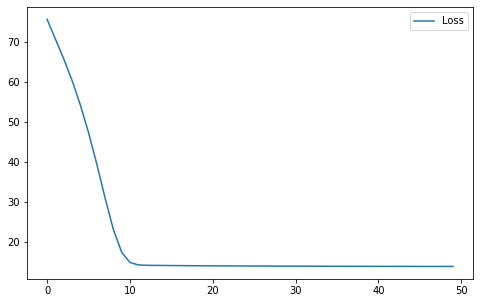

In [18]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()